In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import math

In [2]:
# parameters

t_max = 180             # シミュレーション日数
dt    = 0.001
pop   = 1000000         # シミュレーション人口（100万人）
b     = 1               # ルーズなb
m     = 0.04            # E→S
g     = 0.2 - m         # E -> I 1/incubtation
dh    = 0.007           # mortality in confirmed case（7%）/infectious period（10日）
rh    = 0.093           # d_i + r_i = Constant(1/infectious period（10日）) 
do    = 0.010           # mortality in unconfirmed case（4%）/infectious period（10日）
ro    = 0.090           # d_o + r_o = Constant(1/infectious period（10日）)

#初期状態

Sh = 1
Eh = 1
Ih = 1
Rh = 0
Dh = 0

So = 999900
Eo = 0
Io = 97
Ro = 0
Do = 0

ini_state = [Sh, Eh, Ih, Rh, Dh, So, Eo, Io, Ro, Do
    ]

In [3]:
def sigmoid(a):
    e = math.e
    s = 1 / (1 + e**-a)
    return s

In [4]:
def tSEIRD(v, t, a, m, b, g, rh, dh, ro, do, n, p, Se, Sp, cap):
    beds = np.sum(ini_state) * cap
    return [
        - b * v[0] * v[2]/ (v[0] + v[1] + v[2]) + m * v[1] - a * v[0], #[0] S_h
        b * v[0] * v[2] / (v[0] + v[1] + v[2]) - (m + g) * v[1] + n * (1 - Sp) * v[6] * sigmoid(beds-(v[0]+v[1]+v[2])), #[1] E_h
        g * v[1] - (rh + dh) * v[2] + p * Se * v[7] * sigmoid(beds-(v[0]+v[1]+v[2])), #[2] I_h
        rh * v[2], #[3] R_h
        dh * v[2], #[4] D_h
        - b * v[5] * v[7] / (v[5] + v[6] + v[7] + v[8] + v[3]) + m * v[6] + a * v[0], #[5] S_o
        b * v[5] * v[7] / (v[5] + v[6] + v[7] + v[8] + v[3]) - (m + g) * v[6] - n * (1 - Sp) * v[6] * sigmoid(beds - (v[0]+v[1]+v[2])) ,#[6] E_o
        g * v[6] - (ro + do) * v[7] - p * Se * v[7] * sigmoid(beds - (v[0]+v[1]+v[2])), #[7] I_o
        ro * v[7], #[8] R_o
        do * v[7] #[9] D_o
                ]

In [5]:
def tSEIRD_matrix(Se,Sp,n,p,cap=0.1,a=0):

    times = np.arange(0, t_max, dt)
    args = (a, m, b, g, rh, dh, ro, do, n, p, Se, Sp, cap)

    result = odeint(tSEIRD, ini_state, times, args)

    df = pd.DataFrame(result)
    
    df['Sh'] = df[0]# / 1000
    df['Eh'] = df[1]# / 1000
    df['Ih'] = df[2]# / 1000
    df['Rh'] = df[3]# / 1000
    df['Dh'] = df[4]# / 1000
    
    df['So'] = df[5]# / 1000
    df['Eo'] = df[6]# / 1000
    df['Io'] = df[7]# / 1000
    df['Ro'] = df[8]# / 1000
    df['Do'] = df[9]# / 1000
    
    df['Susceptible'] = (df[0] + df[5])# / 1000 #10
    df['Exposed']     = (df[1] + df[6])# / 1000 #11
    df['Infectious']  = (df[2] + df[7])# / 1000 #12
    df['Recovered']   = (df[3] + df[8])# / 1000 #13
    df['Dead']        = (df[4] + df[9])# / 1000 #14

    df['Hospitalised']= (df[0] + df[1] + df[2])# / 1000 #15
    df['Outside']     = (df[3] + df[5] + df[6] + df[7] + df[8])# / 1000 #16
    
    df['TP']          = (p * Se * df[7])# / 1000 #17
    df['FP']          = (n * (1 - Sp) * df[6])# / 1000 #18
    df['Positive']    = df['TP'] + df['FP'] #19

    df['all']         = (df[0]+df[1]+df[2]+df[3]+df[4]+df[5]+df[6]+df[7]+df[8]+df[9])# / 1000 #20
    df['beta_in']     = b / df['Hospitalised'] #21
    df['beta_out']    = b / df['Outside'] #22
    
    df['delta_Dh']    = dh * df[2]
    df['delta_Do']    = do * df[7]

    df_ = df.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], axis=1)
    
    return df_

In [6]:
def tSEIRD_max(Se,Sp,n,p,cap=0.1,a=0):
    
    times = np.arange(0, t_max, dt)
    args = (a, m, b, g, rh, dh, ro, do, n, p, Se, Sp, cap)

    result = odeint(tSEIRD, ini_state, times, args)

    df = pd.DataFrame(result)
    
    df['Positive'] = (p * Se * df[7]) + (n * (1 - Sp) * df[6])
    df['TP']       = (p * Se * df[7])
    df['FP']       = (n * (1 - Sp) * df[6])

    df['Hospitalised']= df[0] + df[1] + df[2]
    df['Sh'] = df[0]
    df['Eh'] = df[1]
    df['Ih'] = df[2]
    
    df['Io'] = df[7]

    df['Dead']= (df[4] + df[9])
    df['Dh'] = df[4]
    df['Do'] = df[9]
    df['dDead'] = dh * df['Ih'] + do * df['Io']
    
    df_ = df.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], axis=1)
    
    return [dt*np.argmax(df_['Positive']),
            dt*np.argmax(df_['Hospitalised']),
            dt*np.argmax(df_['dDead'])
           ]

# 活性化関数あり版（cap=0.1）

## 検査特性を固定してsurfaceplot

In [7]:
v = []
# 検査特性固定して受診率変えた場合の最大入院者数、死者数、陽性者数

v = []
for i in np.linspace(0,4,161):
    for j in np.linspace(0,0.8,161):
        v.append(tSEIRD_max(0.7,0.7,i,j))

pos_peak_test_fix   = np.array(v)[:, 0].reshape((161,161))
hosp_peak_test_fix  = np.array(v)[:, 1].reshape((161,161))
death_peak_test_fix = np.array(v)[:, 2].reshape((161,161))

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


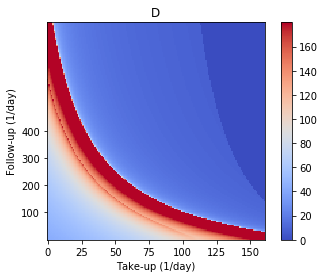

In [8]:
plt.figure()
plt.title('D')#death_test_fix (person)')
plt.xlabel('Take-up (1/day)')
plt.ylabel('Follow-up (1/day)')
plt.imshow(death_peak_test_fix,interpolation='nearest',vmin=np.min(death_peak_test_fix),vmax=np.max(death_peak_test_fix),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

plt.yticks([20, 40, 60, 80], [100, 200, 300, 400])

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

#plt.tight_layout()
plt.show()

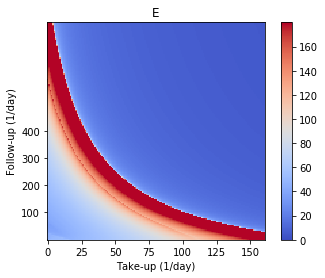

In [9]:
plt.figure()
plt.title('E')#hosp_test_fix (person)')
plt.xlabel('Take-up (1/day)')
plt.ylabel('Follow-up (1/day)')
plt.imshow(hosp_peak_test_fix,interpolation='nearest',vmin=np.min(hosp_peak_test_fix),vmax=np.max(hosp_peak_test_fix),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

plt.yticks([20, 40, 60, 80], [100, 200, 300, 400])

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

#plt.tight_layout()
plt.show()

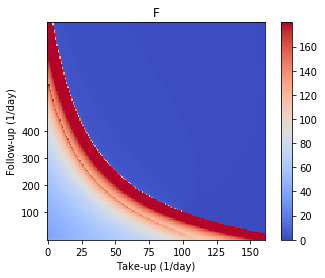

In [10]:
plt.figure()
plt.title('F')#pos_test_fix (person)')
plt.xlabel('Take-up (1/day)')
plt.ylabel('Follow-up (1/day)')
plt.imshow(pos_peak_test_fix,interpolation='nearest',vmin=np.min(pos_peak_test_fix),vmax=np.max(pos_peak_test_fix),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

plt.yticks([20, 40, 60, 80], [100, 200, 300, 400])    

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

#plt.tight_layout()
plt.show()

## 受診率を固定してsurfaceplot

In [11]:
# 受診率固定して検査特性変えた場合の最大入院者数、死者数、陽性者数

t_07 = []
for i in np.linspace(0,1,201):
    for j in np.linspace(0,1,201):
        t_07.append(tSEIRD_max(i,j,0.7,0.7))

pos_peak_visit_fix_07   = np.array(t_07)[:, 0].reshape((201,201))
hosp_peak_visit_fix_07  = np.array(t_07)[:, 1].reshape((201,201))
death_peak_visit_fix_07 = np.array(t_07)[:, 2].reshape((201,201))

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


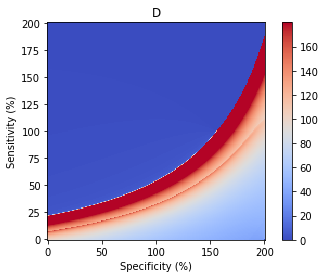

In [12]:
plt.figure()
plt.title('D')#TP (person)')
plt.xlabel('Specificity (%)')
plt.ylabel('Sensitivity (%)')
plt.imshow(pos_peak_visit_fix_07,interpolation='nearest',vmin=np.min(pos_peak_test_fix),vmax=np.max(pos_peak_test_fix),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

#plt.tight_layout()
plt.show()

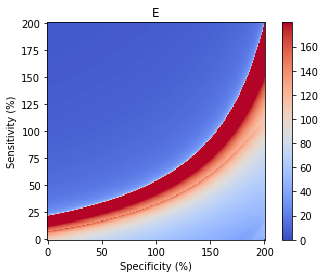

In [13]:
plt.figure()
plt.title('E')#hosp_visit_fix_07 (person)')
plt.xlabel('Specificity (%)')
plt.ylabel('Sensitivity (%)')
plt.imshow(hosp_peak_visit_fix_07,interpolation='nearest',vmin=np.min(hosp_peak_test_fix),vmax=np.max(hosp_peak_test_fix),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

#plt.tight_layout()
plt.show()

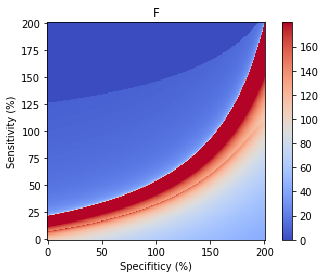

In [14]:
plt.figure()
plt.title('F')#death_visit_fix_07 (person)')
plt.xlabel('Specifiticy (%)')
plt.ylabel('Sensitivity (%)')
plt.imshow(death_peak_visit_fix_07,interpolation='nearest',vmin=np.min(death_peak_test_fix),vmax=np.max(death_peak_test_fix),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

#plt.tight_layout()
plt.show()

# 最大値インデックス探索

In [15]:
np.unravel_index(np.argmax(pos_peak_test_fix), pos_peak_test_fix.shape)

(0, 153)

In [16]:
np.unravel_index(np.argmax(hosp_peak_test_fix), hosp_peak_test_fix.shape)

(0, 150)

In [17]:
np.unravel_index(np.argmax(death_peak_test_fix), death_peak_test_fix.shape)

(0, 150)

In [18]:
np.unravel_index(np.argmax(pos_peak_visit_fix_07), pos_peak_visit_fix_07.shape)

(14, 0)

In [19]:
np.unravel_index(np.argmax(hosp_peak_visit_fix_07), hosp_peak_visit_fix_07.shape)

(12, 0)

In [20]:
np.unravel_index(np.argmax(death_peak_visit_fix_07), death_peak_visit_fix_07.shape)

(12, 0)

# 断面作る用の行列作るよ

In [21]:
# 断面候補
# 途中に最適域があるもの、ないもの
# 100->100,300->60,500->20

In [22]:
import matplotlib.colors as mcolors

c1 = 'tab:blue'
c2 = 'tab:orange'
c3 = 'tab:green'
c4 = 'tab:red'
c5 = 'tab:purple'
c6 = 'tab:brown'
c7 = 'tab:pink'
c8 = 'tab:gray'
c9 = 'tab:olive'
c10= 'tab:cyan'

In [26]:
s1 = []

# follow-up 1から1にひいた線分上をプロット
# f + t = 1
# i.e., f = 1 - t

for i in np.linspace(0,1,201):
    s1.append(tSEIRD_max(0.7,0.7,(1-i),i))

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
df1 = pd.DataFrame({
    'follow_up': 1-(np.linspace(0,0.1,201)),
    'take_up': np.linspace(0,0.1,201),
    'pos1': np.array(s1)[:,0],
    'hos1': np.array(s1)[:,1],
    'des1': np.array(s1)[:,2],
})

df1

,follow_up,take_up,pos1,hos1,des1
0,1.0000,0.0000,55.516,55.244,61.561
1,0.9995,0.0005,56.215,56.055,62.217
2,0.9990,0.0010,56.928,56.662,62.888
3,0.9985,0.0015,57.658,57.395,63.575
4,0.9980,0.0020,58.404,58.143,64.279
...,...,...,...,...,...
196,0.9020,0.0980,0.000,34.891,33.254
197,0.9015,0.0985,0.000,37.026,35.359
198,0.9010,0.0990,0.000,40.134,38.430
199,0.9005,0.0995,0.000,45.435,43.685


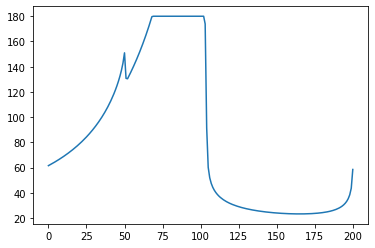

In [28]:
df1['des1'].plot()

In [29]:
s2 = []

# follow-up 3から0.6にひいた線分上をプロット
# f + 5 * t = 3
# i.e., f = 3 - 5 * t

for i in np.linspace(0,0.6,201):
    s2.append(tSEIRD_max(0.7,0.7,(3-5*i),i))

In [30]:
df2 = pd.DataFrame({
    'follow_up': 3-5*(np.linspace(0,0.4,201)),
    'take_up': np.linspace(0,0.4,201),
    'pos2': np.array(s2)[:,0],
    'hos2': np.array(s2)[:,1],
    'des2': np.array(s2)[:,2],
})

df2

,follow_up,take_up,pos2,hos2,des2
0,3.00,0.000,140.284,151.553,154.173
1,2.99,0.002,143.657,154.983,157.584
2,2.98,0.004,147.175,158.558,161.141
3,2.97,0.006,150.847,162.285,164.851
4,2.96,0.008,154.685,166.176,168.726
...,...,...,...,...,...
196,1.04,0.392,124.053,132.934,130.879
197,1.03,0.394,121.069,129.842,127.674
198,1.02,0.396,118.237,126.901,124.618
199,1.01,0.398,115.549,124.101,121.700


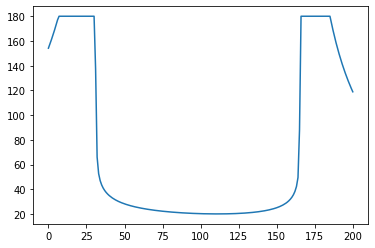

In [31]:
df2['des2'].plot()

In [32]:
s3 = []

# follow-up 5から0.5にひいた線分上をプロット
# f + 10 * t = 5
# i.e., f = 5 - 10 * t

for i in np.linspace(0,0.5,201):
    s3.append(tSEIRD_max(0.7,0.7,(5-10*i),i))

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [33]:
df3 = pd.DataFrame({
    'follow_up': 5-10*(np.linspace(0,0.5,201)),
    'take_up': np.linspace(0,0.5,201),
    'pos3': np.array(s3)[:,0],
    'hos3': np.array(s3)[:,1],
    'des3': np.array(s3)[:,2],
})

df3

,follow_up,take_up,pos3,hos3,des3
0,5.000,0.0000,3.226,35.408,39.019
1,4.975,0.0025,3.123,33.651,37.229
2,4.950,0.0050,3.040,32.204,35.752
3,4.925,0.0075,2.969,30.977,34.498
4,4.900,0.0100,2.909,29.915,33.412
...,...,...,...,...,...
196,0.100,0.4900,121.151,120.825,121.896
197,0.075,0.4925,115.984,115.713,116.555
198,0.050,0.4950,111.355,111.154,111.754
199,0.025,0.4975,107.260,107.149,107.473


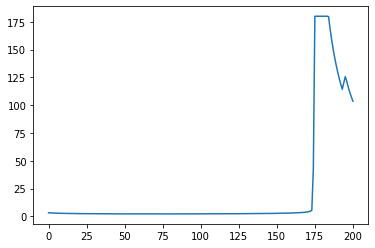

In [34]:
df3['pos3'].plot()

# コスト変化と陽性者数、入院者数、死者数ピークの推移

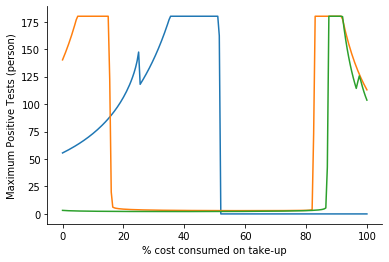

In [35]:
x = np.linspace(0,100,201)
y1 = df1['pos1']
y2 = df2['pos2']
y3 = df3['pos3']

# プロット
plt.title('')#Maximum Hospitalisation on varying ratio of cost for followup and take-up')
plt.xlabel('% cost consumed on take-up')
plt.ylabel('Maximum Positive Tests (person)')

plt.plot(x, y1, label='1', color =c1)
plt.plot(x, y2, label='2', color =c2)
plt.plot(x, y3, label='3', color =c3)

#plt.legend()

#枠線消したい
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.show()

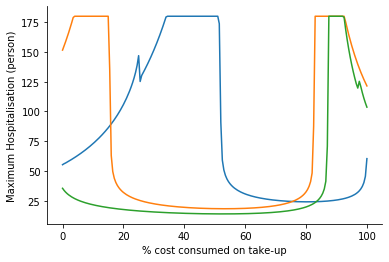

In [36]:
x = np.linspace(0,100,201)
y1 = df1['hos1']
y2 = df2['hos2']
y3 = df3['hos3']

# プロット
plt.title('')#Maximum Hospitalisation on varying ratio of cost for followup and take-up')
plt.xlabel('% cost consumed on take-up')
plt.ylabel('Maximum Hospitalisation (person)')

plt.plot(x, y1, label='1', color =c1)
plt.plot(x, y2, label='2', color =c2)
plt.plot(x, y3, label='3', color =c3)

#plt.legend()

#枠線消したい
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.show()

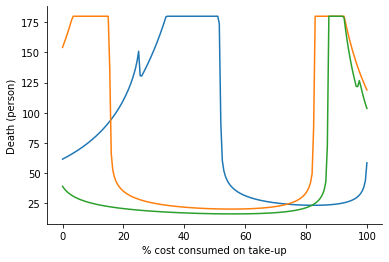

In [37]:
x = np.linspace(0,100,201)
y1 = df1['des1']
y2 = df2['des2']
y3 = df3['des3']

# プロット
plt.title('')#Maximum Hospitalisation on varying ratio of cost for followup and take-up')
plt.xlabel('% cost consumed on take-up')
plt.ylabel('Death (person)')

plt.plot(x, y1, label='1', color =c1)
plt.plot(x, y2, label='2', color =c2)
plt.plot(x, y3, label='3', color =c3)

#plt.legend()

#枠線消したい
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.show()

# 活性化関数なし版（cap=1）

## 検査特性を固定してsurfaceplot

In [38]:
v_1 = []
for i in np.linspace(0,4,161):
    for j in np.linspace(0,0.8,161):
        v_1.append(tSEIRD_max(0.7,0.7,i,j,1))

pos_peak_test_fix_1   = np.array(v_1)[:, 0].reshape((161,161))
hosp_peak_test_fix_1  = np.array(v_1)[:, 1].reshape((161,161))
death_peak_test_fix_1 = np.array(v_1)[:, 2].reshape((161,161))

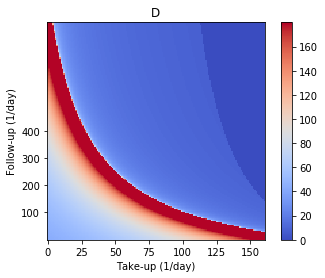

In [39]:
plt.figure()
plt.title('D')#death_test_fix (person)')
plt.xlabel('Take-up (1/day)')
plt.ylabel('Follow-up (1/day)')
plt.imshow(death_peak_test_fix_1,interpolation='nearest',vmin=np.min(death_peak_test_fix_1),vmax=np.max(death_peak_test_fix_1),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

plt.yticks([20, 40, 60, 80], [100, 200, 300, 400])

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

#plt.tight_layout()
plt.show()

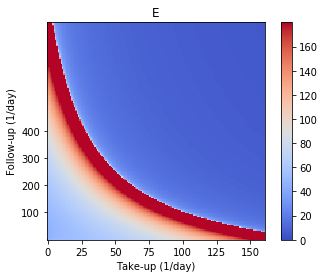

In [40]:
plt.figure()
plt.title('E')#hosp_test_fix (person)')
plt.xlabel('Take-up (1/day)')
plt.ylabel('Follow-up (1/day)')
plt.imshow(hosp_peak_test_fix_1,interpolation='nearest',vmin=np.min(hosp_peak_test_fix_1),vmax=np.max(hosp_peak_test_fix_1),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

plt.yticks([20, 40, 60, 80], [100, 200, 300, 400])

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

#plt.tight_layout()
plt.show()

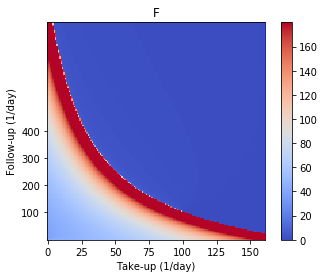

In [41]:
plt.figure()
plt.title('F')#pos_test_fix (person)')
plt.xlabel('Take-up (1/day)')
plt.ylabel('Follow-up (1/day)')
plt.imshow(pos_peak_test_fix_1,interpolation='nearest',vmin=np.min(pos_peak_test_fix_1),vmax=np.max(pos_peak_test_fix_1),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

plt.yticks([20, 40, 60, 80], [100, 200, 300, 400])    

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

#plt.tight_layout()
plt.show()

## 受診率を固定してsurfaceplot

In [43]:
# 受診率固定して検査特性変えた場合の最大入院者数、死者数、陽性者数

t_07_1 = []
for i in np.linspace(0,1,201):
    for j in np.linspace(0,1,201):
        t_07_1.append(tSEIRD_max(i,j,0.7,0.7,1))

pos_peak_visit_fix_07_1   = np.array(t_07_1)[:, 0].reshape((201,201))
hosp_peak_visit_fix_07_1  = np.array(t_07_1)[:, 1].reshape((201,201))
death_peak_visit_fix_07_1 = np.array(t_07_1)[:, 2].reshape((201,201))

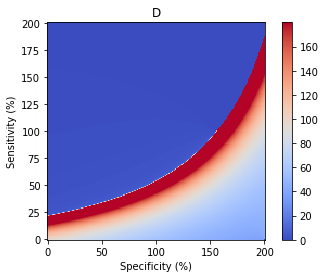

In [44]:
plt.figure()
plt.title('D')#TP (person)')
plt.xlabel('Specificity (%)')
plt.ylabel('Sensitivity (%)')
plt.imshow(pos_peak_visit_fix_07_1,interpolation='nearest',vmin=np.min(pos_peak_test_fix_1),vmax=np.max(pos_peak_test_fix_1),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

#plt.tight_layout()
plt.show()

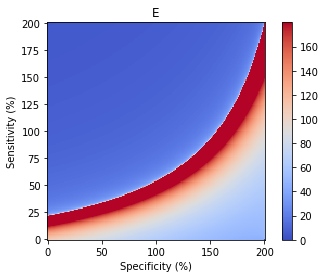

In [45]:
plt.figure()
plt.title('E')#hosp_visit_fix_07 (person)')
plt.xlabel('Specificity (%)')
plt.ylabel('Sensitivity (%)')
plt.imshow(hosp_peak_visit_fix_07_1,interpolation='nearest',vmin=np.min(hosp_peak_test_fix_1),vmax=np.max(hosp_peak_test_fix_1),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

#plt.tight_layout()
plt.show()

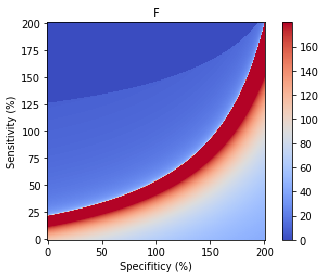

In [46]:
plt.figure()
plt.title('F')#death_visit_fix_07 (person)')
plt.xlabel('Specifiticy (%)')
plt.ylabel('Sensitivity (%)')
plt.imshow(death_peak_visit_fix_07_1,interpolation='nearest',vmin=np.min(death_peak_test_fix_1),vmax=np.max(death_peak_test_fix_1),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

#plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3D.png', dpi=300, bbox_inches='tight')

#plt.tight_layout()
plt.show()

# 最大値インデックス探索

In [50]:
np.unravel_index(np.argmax(death_peak_test_fix_1), death_peak_test_fix_1.shape)

(0, 150)

In [51]:
np.unravel_index(np.argmax(hosp_peak_test_fix_1), hosp_peak_test_fix_1.shape)

(0, 150)

In [52]:
np.unravel_index(np.argmax(death_peak_test_fix_1), death_peak_test_fix_1.shape)

(0, 150)

In [53]:
np.unravel_index(np.argmax(pos_peak_visit_fix_07_1), pos_peak_visit_fix_07_1.shape)

(14, 0)

In [54]:
np.unravel_index(np.argmax(hosp_peak_visit_fix_07_1), hosp_peak_visit_fix_07_1.shape)

(12, 0)

In [55]:
np.unravel_index(np.argmax(death_peak_visit_fix_07_1), death_peak_visit_fix_07_1.shape)

(12, 0)

# 断面作る用の行列作るよ

In [56]:
s1_1 = []

# follow-up 1から1にひいた線分上をプロット
# f + t = 1
# i.e., f = 1 - t

for i in np.linspace(0,1,201):
    s1_1.append(tSEIRD_max(0.7,0.7,(1-i),i,1))

In [57]:
df1_1 = pd.DataFrame({
    'follow_up': 1-(np.linspace(0,0.1,201)),
    'take_up': np.linspace(0,0.1,201),
    'pos1': np.array(s1_1)[:,0],
    'hos1': np.array(s1_1)[:,1],
    'des1': np.array(s1_1)[:,2],
})

df1_1

,follow_up,take_up,pos1,hos1,des1
0,1.0000,0.0000,53.521,60.917,61.852
1,0.9995,0.0005,54.231,61.680,62.559
2,0.9990,0.0010,54.955,62.454,63.280
3,0.9985,0.0015,55.692,63.241,64.017
4,0.9980,0.0020,56.442,64.041,64.770
...,...,...,...,...,...
196,0.9020,0.0980,0.000,34.891,33.254
197,0.9015,0.0985,0.000,37.026,35.359
198,0.9010,0.0990,0.000,40.134,38.430
199,0.9005,0.0995,0.000,45.435,43.685


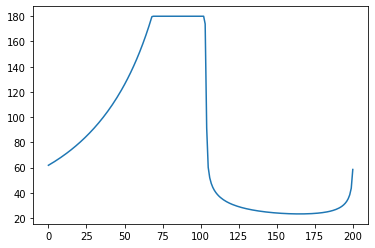

In [58]:
df1_1['des1'].plot()

In [59]:
s2_1 = []

# follow-up 3から0.6にひいた線分上をプロット
# f + 5 * t = 3
# i.e., f = 3 - 5 * t

for i in np.linspace(0,0.6,201):
    s2_1.append(tSEIRD_max(0.7,0.7,(3-5*i),i,1))

In [60]:
df2_1 = pd.DataFrame({
    'follow_up': 3-5*(np.linspace(0,0.4,201)),
    'take_up': np.linspace(0,0.4,201),
    'pos2': np.array(s2_1)[:,0],
    'hos2': np.array(s2_1)[:,1],
    'des2': np.array(s2_1)[:,2],
})

df2_1

,follow_up,take_up,pos2,hos2,des2
0,3.00,0.000,140.284,151.553,154.173
1,2.99,0.002,143.657,154.983,157.584
2,2.98,0.004,147.175,158.558,161.141
3,2.97,0.006,150.847,162.285,164.851
4,2.96,0.008,154.685,166.176,168.726
...,...,...,...,...,...
196,1.04,0.392,124.053,132.934,130.879
197,1.03,0.394,121.069,129.842,127.674
198,1.02,0.396,118.237,126.901,124.618
199,1.01,0.398,115.549,124.101,121.700


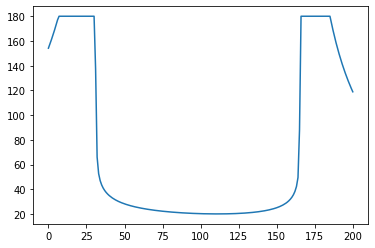

In [61]:
df2_1['des2'].plot()

In [62]:
s3_1 = []

# follow-up 5から0.5にひいた線分上をプロット
# f + 10 * t = 5
# i.e., f = 5 - 10 * t

for i in np.linspace(0,0.5,201):
    s3_1.append(tSEIRD_max(0.7,0.7,(5-10*i),i,1))

In [63]:
df3_1 = pd.DataFrame({
    'follow_up': 5-10*(np.linspace(0,0.5,201)),
    'take_up': np.linspace(0,0.5,201),
    'pos3': np.array(s3_1)[:,0],
    'hos3': np.array(s3_1)[:,1],
    'des3': np.array(s3_1)[:,2],
})

df3_1

,follow_up,take_up,pos3,hos3,des3
0,5.000,0.0000,3.226,35.408,39.019
1,4.975,0.0025,3.123,33.651,37.229
2,4.950,0.0050,3.040,32.204,35.752
3,4.925,0.0075,2.969,30.977,34.498
4,4.900,0.0100,2.909,29.915,33.412
...,...,...,...,...,...
196,0.100,0.4900,102.296,110.878,108.823
197,0.075,0.4925,98.898,107.333,105.089
198,0.050,0.4950,95.757,104.045,101.602
199,0.025,0.4975,92.853,100.993,98.339


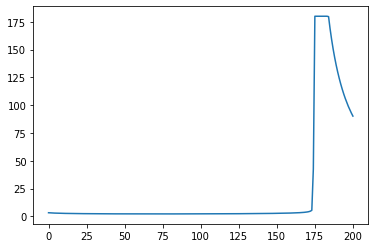

In [64]:
df3_1['pos3'].plot()

# コスト変化と陽性者数、入院者数、死者数ピークの推移

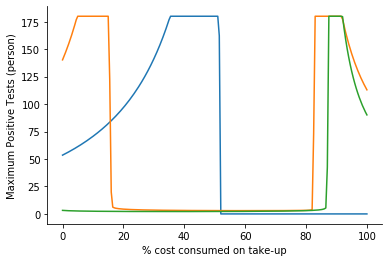

In [65]:
x = np.linspace(0,100,201)
y1 = df1_1['pos1']
y2 = df2_1['pos2']
y3 = df3_1['pos3']

# プロット
plt.title('')#Maximum Hospitalisation on varying ratio of cost for followup and take-up')
plt.xlabel('% cost consumed on take-up')
plt.ylabel('Maximum Positive Tests (person)')

plt.plot(x, y1, label='1', color =c1)
plt.plot(x, y2, label='2', color =c2)
plt.plot(x, y3, label='3', color =c3)

#plt.legend()

#枠線消したい
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.show()

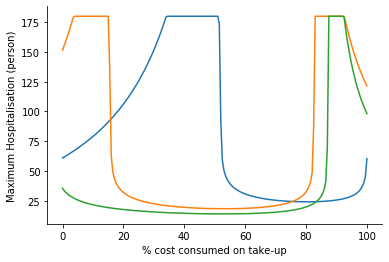

In [66]:
x = np.linspace(0,100,201)
y1 = df1_1['hos1']
y2 = df2_1['hos2']
y3 = df3_1['hos3']

# プロット
plt.title('')#Maximum Hospitalisation on varying ratio of cost for followup and take-up')
plt.xlabel('% cost consumed on take-up')
plt.ylabel('Maximum Hospitalisation (person)')

plt.plot(x, y1, label='1', color =c1)
plt.plot(x, y2, label='2', color =c2)
plt.plot(x, y3, label='3', color =c3)

#plt.legend()

#枠線消したい
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.show()

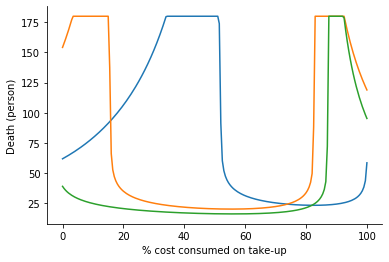

In [67]:
x = np.linspace(0,100,201)
y1 = df1_1['des1']
y2 = df2_1['des2']
y3 = df3_1['des3']

# プロット
plt.title('')#Maximum Hospitalisation on varying ratio of cost for followup and take-up')
plt.xlabel('% cost consumed on take-up')
plt.ylabel('Death (person)')

plt.plot(x, y1, label='1', color =c1)
plt.plot(x, y2, label='2', color =c2)
plt.plot(x, y3, label='3', color =c3)

#plt.legend()

#枠線消したい
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.show()

In [68]:
from email import message
import smtplib
 

smtp_host = 'smtp.gmail.com'   # メールを送るSMTPサーバー
smtp_port = 587   # ポート番号
from_email = 'bougtoir@gmail.com'   # 送信元のメールアドレス(Gmeilアドレス)
to_email = 'bougtoir@gmail.com'   # 送信先のメールアドレス
username = 'bougtoir@gmail.com'   # ユーザーネームはGoogleアカウント（Gmailアドレス）
password = 'asalxwpzjstooggg'   # Googleアカウントのパスワード
 
# 送信メールを作成する
msg = message.EmailMessage()   # メッセージオブジェクトを作成
msg.set_content('tSEIRD_peak_1109の結果出たよ！')   # メール本文
msg['Subject'] = 'note from python'   # メールのタイトル（件名）
msg['From'] = from_email   # メール送信元
msg['To'] = to_email   # メール送信先
 
# メールサーバーへアクセスする
server = smtplib.SMTP(smtp_host, smtp_port)
server.ehlo()
server.starttls()
server.ehlo()
server.login(username, password)
server.send_message(msg)
server.quit()

(221, b'2.0.0 closing connection z7sm6032015pfr.140 - gsmtp')